# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [23]:
from api_keys import (weather_api_key, g_key)
from citipy import citipy
import datetime
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from random import uniform
import requests
from scipy.stats import linregress

## Generate Cities List

In [2]:
#Randomly select at least 500 unique (non-repeat) cities based on latitude and longitude.
# default 643

In [3]:
# Lists for holding data
number_of_cities = 643
cities = []

while len(cities) < number_of_cities:  
    lon, lat = uniform(-180,180), uniform(-90, 90)       
    city = citipy.nearest_city(lon, lat)   
    city_name = city.city_name          
    if city_name not in cities:                
        cities.append(city_name)
            
cities

['dikson',
 'ostrovnoy',
 'ponta do sol',
 'ushuaia',
 'belushya guba',
 'san cristobal',
 'bredasdorp',
 'olafsvik',
 'touba',
 'qaanaaq',
 'saldanha',
 'taolanaro',
 'barentsburg',
 'punta arenas',
 'jacqueville',
 'albany',
 'port alfred',
 'vila franca do campo',
 'straumen',
 'hermanus',
 'kaabong',
 'saint-philippe',
 'longyearbyen',
 'sao filipe',
 'cidreira',
 'kruisfontein',
 'victoria',
 'maniitsoq',
 'upernavik',
 'jamestown',
 'torbay',
 'illoqqortoormiut',
 'laguna',
 'privokzalnyy',
 'mecca',
 'talara',
 'puerto leguizamo',
 'kavali',
 'santa cruz de tenerife',
 'kilindoni',
 'tasiilaq',
 'hithadhoo',
 'port elizabeth',
 'mahebourg',
 'maceio',
 'kalmunai',
 'guider',
 'cape town',
 'arlit',
 'clyde river',
 'bargal',
 'bubaque',
 'newcastle',
 'koungou',
 'atar',
 'mao',
 'inta',
 'huarmey',
 'grand gaube',
 'carutapera',
 'henties bay',
 'klaksvik',
 'ribeira grande',
 'santa barbara',
 'pizarro',
 'turukhansk',
 'oktyabrskoye',
 'narsaq',
 'berlevag',
 'new waterford',

### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [4]:
# Save config information.
url = "http://api.openweathermap.org/data/2.5/weather?"

params = {
    "units": "metric", 
    "appid": weather_api_key,
    "q": ""
}

In [8]:
# set up lists to hold reponse info
Name = []
Lat = []
Lng = []
Max_Temp = []
Humidity = []
Cloudiness = []
Wind_Speed = []
Country = []
Date = []

In [9]:
print('Beginning Data Retrieval')
print('-----------------------------')

sets = 1
records = 1

for i, city in enumerate(cities):
    
    if (i % 50 == 0 and i >= 2):
        sets += 1
        records = 1
    
    params['q'] = city
    response = requests.get(url, params=params).json()

    print(f"Processing Record {records} of Set {sets} | {city}")    
    
    try:
        Lat.append(response['coord']['lat'])
        Lng.append(response['coord']['lon'])
        Max_Temp.append(response['main']['temp_max'])
        Humidity.append(response['main']['humidity'])
        Cloudiness.append(response['clouds']['all'])
        Wind_Speed.append(response['wind']['speed'])
        Country.append(response['sys']['country'])
        Date.append(response['dt'])
        Name.append(city)
     
    except:
        print("City not found. Skipping...")
        pass
    
    records +=1      

print('-----------------------------')        
print('Data Retrieval Complete ')
print('-----------------------------')  

Beginning Data Retrieval
-----------------------------
Processing Record 1 of Set 1 | dikson
Processing Record 2 of Set 1 | ostrovnoy
Processing Record 3 of Set 1 | ponta do sol
Processing Record 4 of Set 1 | ushuaia
Processing Record 5 of Set 1 | belushya guba
City not found. Skipping...
Processing Record 6 of Set 1 | san cristobal
Processing Record 7 of Set 1 | bredasdorp
Processing Record 8 of Set 1 | olafsvik
Processing Record 9 of Set 1 | touba
Processing Record 10 of Set 1 | qaanaaq
Processing Record 11 of Set 1 | saldanha
Processing Record 12 of Set 1 | taolanaro
City not found. Skipping...
Processing Record 13 of Set 1 | barentsburg
City not found. Skipping...
Processing Record 14 of Set 1 | punta arenas
Processing Record 15 of Set 1 | jacqueville
Processing Record 16 of Set 1 | albany
Processing Record 17 of Set 1 | port alfred
Processing Record 18 of Set 1 | vila franca do campo
Processing Record 19 of Set 1 | straumen
Processing Record 20 of Set 1 | hermanus
Processing Recor

Processing Record 36 of Set 4 | tawkar
City not found. Skipping...
Processing Record 37 of Set 4 | saint-augustin
Processing Record 38 of Set 4 | kulhudhuffushi
Processing Record 39 of Set 4 | robore
Processing Record 40 of Set 4 | hwange
Processing Record 41 of Set 4 | pachino
Processing Record 42 of Set 4 | araioses
Processing Record 43 of Set 4 | lokosovo
Processing Record 44 of Set 4 | skjervoy
Processing Record 45 of Set 4 | najran
Processing Record 46 of Set 4 | floresti
Processing Record 47 of Set 4 | caravelas
Processing Record 48 of Set 4 | general roca
Processing Record 49 of Set 4 | los llanos de aridane
Processing Record 50 of Set 4 | umm lajj
Processing Record 1 of Set 5 | garissa
Processing Record 2 of Set 5 | gazanjyk
Processing Record 3 of Set 5 | dekar
Processing Record 4 of Set 5 | karpathos
Processing Record 5 of Set 5 | terre haute
Processing Record 6 of Set 5 | general pico
Processing Record 7 of Set 5 | abalak
Processing Record 8 of Set 5 | radovitskiy
Processing 

Processing Record 27 of Set 8 | lapua
Processing Record 28 of Set 8 | chirongui
Processing Record 29 of Set 8 | lucea
Processing Record 30 of Set 8 | the valley
Processing Record 31 of Set 8 | asyut
Processing Record 32 of Set 8 | sompeta
Processing Record 33 of Set 8 | abu samrah
Processing Record 34 of Set 8 | tokmak
Processing Record 35 of Set 8 | mahibadhoo
Processing Record 36 of Set 8 | roald
Processing Record 37 of Set 8 | qandahar
City not found. Skipping...
Processing Record 38 of Set 8 | slavgorodskoye
Processing Record 39 of Set 8 | meshchovsk
Processing Record 40 of Set 8 | goundam
Processing Record 41 of Set 8 | belmonte
Processing Record 42 of Set 8 | qasigiannguit
Processing Record 43 of Set 8 | dehloran
Processing Record 44 of Set 8 | mayor pablo lagerenza
Processing Record 45 of Set 8 | aksarka
Processing Record 46 of Set 8 | ituni
City not found. Skipping...
Processing Record 47 of Set 8 | caxito
Processing Record 48 of Set 8 | la palma
Processing Record 49 of Set 8 |

Processing Record 17 of Set 12 | chokwe
Processing Record 18 of Set 12 | lawrenceburg
Processing Record 19 of Set 12 | okandja
City not found. Skipping...
Processing Record 20 of Set 12 | zhanatas
City not found. Skipping...
Processing Record 21 of Set 12 | busayra
Processing Record 22 of Set 12 | coihaique
Processing Record 23 of Set 12 | severnoye
Processing Record 24 of Set 12 | ilorin
Processing Record 25 of Set 12 | terra santa
Processing Record 26 of Set 12 | itaituba
Processing Record 27 of Set 12 | preobrazhenskaya
City not found. Skipping...
Processing Record 28 of Set 12 | nyakahanga
Processing Record 29 of Set 12 | moose factory
Processing Record 30 of Set 12 | fulnek
Processing Record 31 of Set 12 | camacha
Processing Record 32 of Set 12 | jaynagar-majilpur
Processing Record 33 of Set 12 | achisay
City not found. Skipping...
Processing Record 34 of Set 12 | puerto narino
Processing Record 35 of Set 12 | jinka
Processing Record 36 of Set 12 | ipora
Processing Record 37 of Se

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [44]:
# create a data frame from cities, lat, and temp
weather_dict = {
    "City": Name,
    "Lat": Lat,
    "Lng": Lng,
    "Max Temp": Max_Temp,
    "Humidity": Humidity,
    "Cloudiness": Cloudiness,    
    "Wind Speed": Wind_Speed,
    "Country": Country,
    "Date": Date,
}

weather_df = pd.DataFrame(weather_dict)
weather_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,dikson,73.5069,80.5464,-32.02,97,56,3.95,RU,1616122375
1,ostrovnoy,68.0531,39.5131,-10.47,84,99,2.64,RU,1616122471
2,ponta do sol,32.6667,-17.1000,16.67,67,20,4.12,PT,1616122401
3,ushuaia,-54.8000,-68.3000,8.00,71,40,2.06,AR,1616122295
4,san cristobal,7.7669,-72.2250,24.00,100,75,2.06,VE,1616122448


In [11]:
weather_df.describe()

,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,5.930000e+02
mean,19.668356,3.945216,13.029275,74.372681,54.229342,3.233895,1.616123e+09
std,30.937124,57.290985,13.290288,21.988504,40.554326,2.581405,2.102747e+02
min,-54.800000,-121.423800,-32.020000,10.000000,0.000000,0.210000,1.616122e+09
25%,-3.748100,-52.869900,4.000000,66.000000,5.000000,1.540000,1.616122e+09
50%,21.116700,13.811000,16.930000,81.000000,64.000000,2.550000,1.616123e+09
75%,44.880000,46.273500,23.720000,91.000000,96.000000,4.120000,1.616123e+09
max,78.218600,153.566700,36.000000,100.000000,100.000000,17.880000,1.616123e+09


In [12]:
weather_df[['City', 'Cloudiness', 'Country','Date', 'Humidity', 'Lat', 'Lng', 'Max Temp', 'Wind Speed']].to_csv("../output_data/cities.csv", encoding="utf-8", index=True, header=True, index_label="City_ID")


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [13]:
#  Get the indices of cities that have humidity over 100%.
indexNames = weather_df[weather_df['Humidity'] > 100].index

In [14]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
# Passing "inplace=False" will make a copy of the city_data DataFrame, which we call "clean_city_data".
clean_city_df = weather_df.drop(indexNames, inplace=False)

In [15]:
clean_city_df.describe()

,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,5.930000e+02
mean,19.668356,3.945216,13.029275,74.372681,54.229342,3.233895,1.616123e+09
std,30.937124,57.290985,13.290288,21.988504,40.554326,2.581405,2.102747e+02
min,-54.800000,-121.423800,-32.020000,10.000000,0.000000,0.210000,1.616122e+09
25%,-3.748100,-52.869900,4.000000,66.000000,5.000000,1.540000,1.616122e+09
50%,21.116700,13.811000,16.930000,81.000000,64.000000,2.550000,1.616123e+09
75%,44.880000,46.273500,23.720000,91.000000,96.000000,4.120000,1.616123e+09
max,78.218600,153.566700,36.000000,100.000000,100.000000,17.880000,1.616123e+09


## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

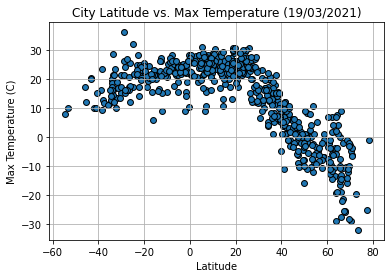

In [32]:
lat_temp_pl = clean_city_df.plot(kind="scatter", x="Lat", y="Max Temp", grid=True, figsize=(6,4), facecolors="blue", edgecolors="black", s=35,
              title=(f'City Latitude vs. Max Temperature (19/03/2021)'))


lat_temp_pl.set_xlabel("Latitude")
lat_temp_pl.set_ylabel("Max Temperature (C)")

plt.savefig("../output_data/TemperatureVsLatitude.png")
plt.show()

## Latitude vs. Humidity Plot

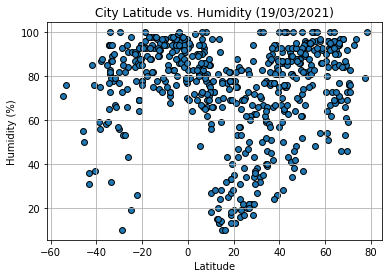

In [33]:
lat_hum_pl = clean_city_df.plot(kind="scatter", x="Lat", y="Humidity", grid=True, figsize=(6,4), facecolors="blue", edgecolors="black", s=35,
              title=(f'City Latitude vs. Humidity (19/03/2021)'))


lat_hum_pl.set_xlabel("Latitude")
lat_hum_pl.set_ylabel("Humidity (%)")

plt.savefig("../output_data/HumidityVsLatitude.png")
plt.show()

## Latitude vs. Cloudiness Plot

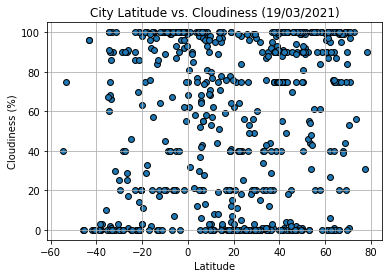

In [34]:
lat_cloud_pl = clean_city_df.plot(kind="scatter", x="Lat", y="Cloudiness", grid=True, figsize=(6,4), facecolors="blue", edgecolors="black", s=35,
              title=(f'City Latitude vs. Cloudiness (19/03/2021)'))


lat_cloud_pl.set_xlabel("Latitude")
lat_cloud_pl.set_ylabel("Cloudiness (%)")

plt.savefig("../output_data/CloudinessVsLatitude.png")
plt.show()

## Latitude vs. Wind Speed Plot

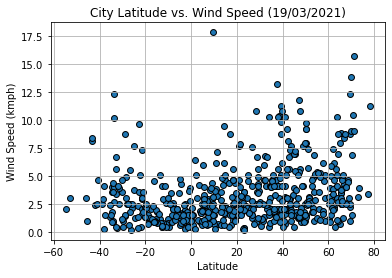

In [35]:
lat_wind_pl = clean_city_df.plot(kind="scatter", x="Lat", y="Wind Speed", grid=True, figsize=(6,4), facecolors="blue", edgecolors="black", s=35,
              title=(f'City Latitude vs. Wind Speed (19/03/2021)'))

lat_wind_pl.set_xlabel("Latitude")
lat_wind_pl.set_ylabel("Wind Speed (kmph)")

plt.savefig("../output_data/WindSpeedVsLatitude.png")
plt.show()

## Linear Regression

In [20]:
northern_hem_df = clean_city_df.loc[clean_city_df['Lat'] >= 0 ].copy()

southern_hem_df = clean_city_df.loc[clean_city_df['Lat'] < 0 ].copy()

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.7812231558362853


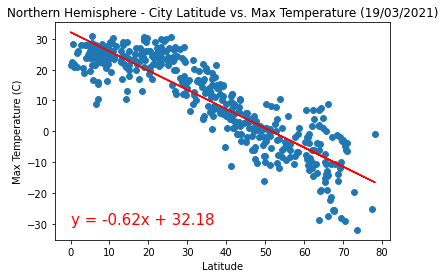

In [36]:
nor_temp_pl = northern_hem_df.plot(kind="scatter", x="Lat", y="Max Temp", figsize=(6,4), facecolors="blue", s=35,
              title=(f'Northern Hemisphere - City Latitude vs. Max Temperature (19/03/2021)'))

(slope_nt, intercept_nt, rvalue_nt, pvalue_nt, stderr_nt) = linregress(northern_hem_df['Lat'], northern_hem_df['Max Temp'])

print(f"The r-squared is: {rvalue_nt**2}")

regress_values_nt = northern_hem_df['Lat'] * slope_nt + intercept_nt
line_eq_nt = "y = " + str(round(slope_nt,2)) + "x + " + str(round(intercept_nt,2))

nor_temp_pl.plot(northern_hem_df['Lat'],regress_values_nt,"r-")
nor_temp_pl.annotate(line_eq_nt,(0,-30),fontsize=15,color="red")

nor_temp_pl.set_xlabel("Latitude")
nor_temp_pl.set_ylabel("Max Temperature (C)")

plt.show()

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.2120497134247173


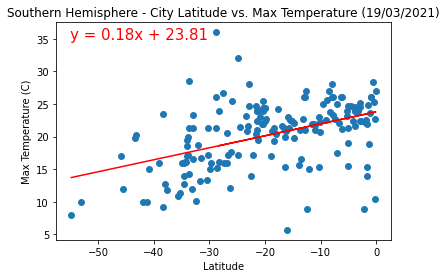

In [46]:
sou_temp_pl = southern_hem_df.plot(kind="scatter", x="Lat", y="Max Temp", figsize=(6,4), facecolors="blue", s=35,
              title=(f'Southern Hemisphere - City Latitude vs. Max Temperature (19/03/2021)'))

(slope_st, intercept_st, rvalue_st, pvalue_st, stderr_st) = linregress(southern_hem_df['Lat'], southern_hem_df['Max Temp'])

print(f"The r-squared is: {rvalue_st**2}")

regress_values_st = southern_hem_df['Lat'] * slope_st + intercept_st
line_eq_st = "y = " + str(round(slope_st,2)) + "x + " + str(round(intercept_st,2))

sou_temp_pl.plot(southern_hem_df['Lat'],regress_values_st,"r-")
sou_temp_pl.annotate(line_eq_st,(-55,35),fontsize=15,color="red")

sou_temp_pl.set_xlabel("Latitude")
sou_temp_pl.set_ylabel("Max Temperature (C)")

plt.show()

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.07720533040901903


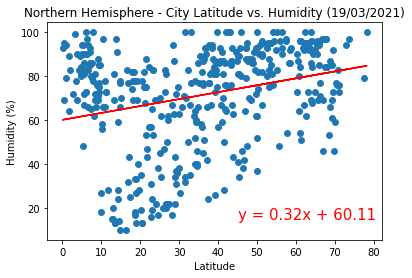

In [48]:
nor_hum_pl = northern_hem_df.plot(kind="scatter", x="Lat", y="Humidity", figsize=(6,4), facecolors="blue", s=35,
              title=(f'Northern Hemisphere - City Latitude vs. Humidity (19/03/2021)'))

(slope_nh, intercept_nh, rvalue_nh, pvalue_nh, stderr_nh) = linregress(northern_hem_df['Lat'], northern_hem_df['Humidity'])

print(f"The r-squared is: {rvalue_nh**2}")

regress_values_nh = northern_hem_df['Lat'] * slope_nh + intercept_nh
line_eq_nh = "y = " + str(round(slope_nh,2)) + "x + " + str(round(intercept_nh,2))

nor_hum_pl.plot(northern_hem_df['Lat'],regress_values_nh,"r-")
nor_hum_pl.annotate(line_eq_nh,(45,15),fontsize=15,color="red")

nor_hum_pl.set_xlabel("Latitude")
nor_hum_pl.set_ylabel("Humidity (%)")

plt.show()

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.1943925558146307


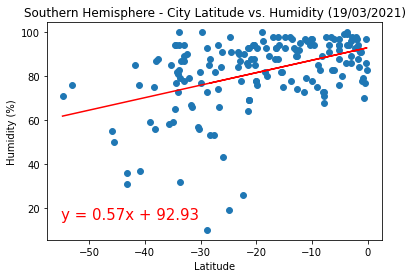

In [49]:
sou_hum_pl = southern_hem_df.plot(kind="scatter", x="Lat", y="Humidity", figsize=(6,4), facecolors="blue", s=35,
              title=(f'Southern Hemisphere - City Latitude vs. Humidity (19/03/2021)'))

(slope_sh, intercept_sh, rvalue_sh, pvalue_sh, stderr_sh) = linregress(southern_hem_df['Lat'], southern_hem_df['Humidity'])

print(f"The r-squared is: {rvalue_sh**2}")

regress_values_sh = southern_hem_df['Lat'] * slope_sh + intercept_sh
line_eq_sh = "y = " + str(round(slope_sh,2)) + "x + " + str(round(intercept_sh,2))

sou_hum_pl.plot(southern_hem_df['Lat'],regress_values_sh,"r-")
sou_hum_pl.annotate(line_eq_sh,(-55,15),fontsize=15,color="red")

sou_hum_pl.set_xlabel("Latitude")
sou_hum_pl.set_ylabel("Humidity (%)")

plt.show()

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.03206722381573628


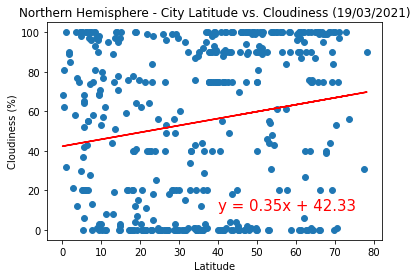

In [50]:
nor_cloud_pl = northern_hem_df.plot(kind="scatter", x="Lat", y="Cloudiness", figsize=(6,4), facecolors="blue", s=35,
              title=(f'Northern Hemisphere - City Latitude vs. Cloudiness (19/03/2021)'))

(slope_nc, intercept_nc, rvalue_nc, pvalue_nc, stderr_nc) = linregress(northern_hem_df['Lat'], northern_hem_df['Cloudiness'])

print(f"The r-squared is: {rvalue_nc**2}")

regress_values_nc = northern_hem_df['Lat'] * slope_nc + intercept_nc
line_eq_nc = "y = " + str(round(slope_nc,2)) + "x + " + str(round(intercept_nc,2))

nor_cloud_pl.plot(northern_hem_df['Lat'],regress_values_nc,"r-")
nor_cloud_pl.annotate(line_eq_nc,(40,10),fontsize=15,color="red")

nor_cloud_pl.set_xlabel("Latitude")
nor_cloud_pl.set_ylabel("Cloudiness (%)")

plt.show()

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.15790714311319146


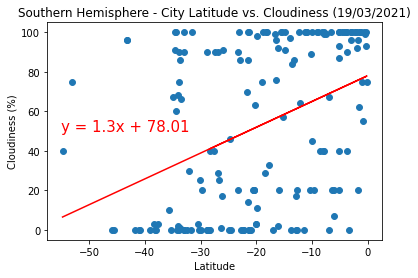

In [51]:
sou_cloud_pl = southern_hem_df.plot(kind="scatter", x="Lat", y="Cloudiness", figsize=(6,4), facecolors="blue", s=35,
              title=(f'Southern Hemisphere - City Latitude vs. Cloudiness (19/03/2021)'))

(slope_sc, intercept_sc, rvalue_sc, pvalue_sc, stderr_sc) = linregress(southern_hem_df['Lat'], southern_hem_df['Cloudiness'])

print(f"The r-squared is: {rvalue_sc**2}")

regress_values_sc = southern_hem_df['Lat'] * slope_sc + intercept_sc
line_eq_sc = "y = " + str(round(slope_sc,2)) + "x + " + str(round(intercept_sc,2))

sou_cloud_pl.plot(southern_hem_df['Lat'],regress_values_sc,"r-")
sou_cloud_pl.annotate(line_eq_sc,(-55,50),fontsize=15,color="red")

sou_cloud_pl.set_xlabel("Latitude")
sou_cloud_pl.set_ylabel("Cloudiness (%)")

plt.show()

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 0.08439243577010974


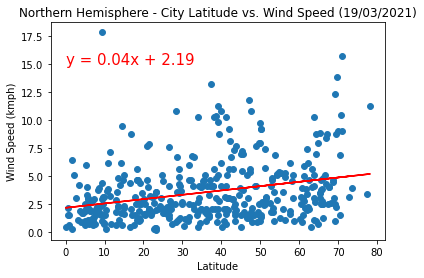

In [52]:
nor_wind_pl = northern_hem_df.plot(kind="scatter", x="Lat", y="Wind Speed", figsize=(6,4), facecolors="blue", s=35,
              title=(f'Northern Hemisphere - City Latitude vs. Wind Speed (19/03/2021)'))

(slope_nw, intercept_nw, rvalue_nw, pvalue_nw, stderr_nw) = linregress(northern_hem_df['Lat'], northern_hem_df['Wind Speed'])

print(f"The r-squared is: {rvalue_nw**2}")

regress_values_nw = northern_hem_df['Lat'] * slope_nw + intercept_nw
line_eq_nw = "y = " + str(round(slope_nw,2)) + "x + " + str(round(intercept_nw,2))

nor_wind_pl.plot(northern_hem_df['Lat'],regress_values_nw,"r-")
nor_wind_pl.annotate(line_eq_nw,(0,15.0),fontsize=15,color="red")

nor_wind_pl.set_xlabel("Latitude")
nor_wind_pl.set_ylabel("Wind Speed (kmph)")

plt.show()

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 0.10946126523165553


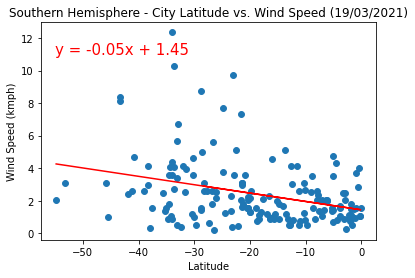

In [53]:
sou_wind_pl = southern_hem_df.plot(kind="scatter", x="Lat", y="Wind Speed", figsize=(6,4), facecolors="blue", s=35,
              title=(f'Southern Hemisphere - City Latitude vs. Wind Speed (19/03/2021)'))

(slope_sw, intercept_sw, rvalue_sw, pvalue_sw, stderr_sw) = linregress(southern_hem_df['Lat'], southern_hem_df['Wind Speed'])

print(f"The r-squared is: {rvalue_sw**2}")

regress_values_sw = southern_hem_df['Lat'] * slope_sw + intercept_sw
line_eq_sw = "y = " + str(round(slope_sw,2)) + "x + " + str(round(intercept_sw,2))

sou_wind_pl.plot(southern_hem_df['Lat'],regress_values_sw,"r-")
sou_wind_pl.annotate(line_eq_sw,(-55,11),fontsize=15,color="red")

sou_wind_pl.set_xlabel("Latitude")
sou_wind_pl.set_ylabel("Wind Speed (kmph)")

plt.show()